# Install required libraries

In [ ]:
#imports.... Run this each time after restarting the Kernel
!pip install watson_developer_cloud
# Run pip install only the first time, once installed on your Spark machine, no need to re-run unless you want to upgrade
!pip install --upgrade --force-reinstall wordcloud
!pip install --user --upgrade pixiedust

# Import libraries

In [8]:
# Cloud Object Storage 
from botocore.client import Config
import ibm_boto3

# General Python libraries
import requests
import json
import io
from os.path import join, dirname

# Import Watson services
import watson_developer_cloud as watson
from watson_developer_cloud import SpeechToTextV1, NaturalLanguageUnderstandingV1, NaturalLanguageClassifierV1, ToneAnalyzerV3
from watson_developer_cloud.natural_language_understanding.features import (
    v1 as Features)


# Import libraries for analytics part
import pixiedust
from pixiedust.display import *

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

import matplotlib.pyplot as plt

from pyspark.sql import functions as F
from pyspark.sql.functions import col

Pixiedust database opened successfully


# Cloud Object Storage read-only credentials

In [3]:
credentials_os = {
  "apikey": "kfJa4az-NCI5itJaVJOmr2V4T3JnhS7E-0dxMact1HY2",
  "cos_hmac_keys": {
    "access_key_id": "d333abb1cb604803a16a1de30258be1c",
    "secret_access_key": "ee495ee9dd54eda842bf3b00f7a00d1a26c6bcb0cd7f9934"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/8739a0c318b37263a932b45c1947965d:7ce353a1-fa6f-4e25-a311-e29b0b2a8ad8::",
  "iam_apikey_name": "auto-generated-apikey-d333abb1-cb60-4803-a16a-1de30258be1c",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Reader",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/8739a0c318b37263a932b45c1947965d::serviceid:ServiceId-cb9435ef-c3f6-42ed-9f8e-855d3345a4b8",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/8739a0c318b37263a932b45c1947965d:7ce353a1-fa6f-4e25-a311-e29b0b2a8ad8::"
}

credentials_os['BUCKET'] = 'watsoncallcenterthink18c8855d42de924dc38ccd02f3a8a50d7f'

# Burner credentials for Watson Services

Credentials will only be available till April 26, 2018; afterward you need to create your own services and train your own classifier


In [ ]:

credentials_nlu = {
  "url": "https://gateway.watsonplatform.net/natural-language-understanding/api",
  "username": "f3c6267a-e3d0-4a1c-86fa-1d88b43df149",
  "password": "AafrKOBcU5mX"
}

# Ground truth used - simple tester "call_center_gt_NLC_V2.csv"
# https://github.com/rustyoldrake/call_center_instrumentation_analytics/blob/master/call_center_gt_NLC_V2.csv
credentials_nlc = {
    "classifier_id": "f7ea68x308-nlc-917",
    "url": "https://gateway.watsonplatform.net/natural-language-classifier/api",
    "username": "8f94db77-2cec-45ad-aa07-a76ff9c2a3d5",
    "password": "tzdUqQIeVwCZ",
}

credentials_tone = {
  "url": "https://gateway.watsonplatform.net/tone-analyzer/api",
  "username": "a21a52c9-f61a-42c1-babd-5e164ac05355",
  "password": "SzFi0IaqUek6"
}



# Sample Audio Files

In [13]:
# List of files which were transcribed by STT and enriched with NLU
file_list = ['sample1-addresschange-positive.ogg',
             'sample2-address-negative.ogg',
             'sample3-shirt-return-weather-chitchat.ogg',
             'sample4-angryblender-sportschitchat-recovery.ogg',
             'sample5-calibration-toneandcontext.ogg',
             'jfk_1961_0525_speech_to_put_man_on_moon.ogg',
             'May 1 1969 Fred Rogers testifies before the Senate Subcommittee on Communications.ogg']

# Setup Object Storage

In [11]:
def set_up_object_storage(credentials_object_storage):
    endpoints = requests.get(credentials_object_storage['endpoints']).json()

    iam_host = (endpoints['identity-endpoints']['iam-token'])
    cos_host = (endpoints['service-endpoints']['cross-region']['us']['public']['us-geo'])

    auth_endpoint = "https://" + iam_host + "/oidc/token"
    service_endpoint = "https://" + cos_host


    client = ibm_boto3.client(
        's3',
        ibm_api_key_id = credentials_object_storage['apikey'],
        ibm_service_instance_id = credentials_object_storage['resource_instance_id'],
        ibm_auth_endpoint = auth_endpoint,
        config = Config(signature_version='oauth'),
        endpoint_url = service_endpoint
       )
    return client

client = set_up_object_storage(credentials_os)

# Set up Watson Speech To Text

In [ ]:

# speech_to_text = SpeechToTextV1(
#     username = credentials_stt['username'],
#     password = credentials_stt['password'],
#     url = 'https://stream.watsonplatform.net/speech-to-text/api',
# )

def get_transcript(audio):
    transcript = json.dumps(speech_to_text.recognize(audio=audio, content_type='audio/ogg', timestamps=True,
        word_confidence=True), indent=2)
    return transcript

def analyze_sample(sample):
    streaming_body = client.get_object(Bucket = credentials_os['BUCKET'], Key=sample)['Body'] #http
    audio = streaming_body.read()
    text = get_transcript(audio)
    # client.put_object(Bucket = credentials_os['BUCKET'], Key = sample.split('.')[0] + '_text.json', Body = text) ## Already done for Demo purposes
    return text



# Setup Watson Natural Language Understanding

In [ ]:
features = { "concepts":{},"entities":{},"keywords":{},"categories":{},"emotion":{},"sentiment":{},"semantic_roles":{} }

natural_language_understanding = NaturalLanguageUnderstandingV1(
    version = '2017-02-27',
    username = credentials_nlu['username'],
    password = credentials_nlu['password']
)

chunk_size=25 # This CHUNK size is used to disaggregate a transcript 
#e.g. in this case a 290 word transcript would have 10 chunks - 9 with 30 words and 1 with 20 words - approximates 'time domain' for this lab

def chunk_transcript(transcript, chunk_size):
    transcript = transcript.split(' ')
    return [ transcript[i:i+chunk_size] for i in range(0, len(transcript), chunk_size) ] # chunking data

def process_text_chunks(text):
    transcript=''
    for sentence in json.loads(text)['results']:
        transcript = transcript + sentence['alternatives'][0]['transcript'] # concatenate sentences
    transcript = chunk_transcript(transcript, chunk_size) # chunk the transcript
    return  transcript

def analyze_transcript_chunks(features, file_name):
    streaming_body = client.get_object(Bucket = credentials_os['BUCKET'], Key=file_name.split('.')[0]+'_text.json')['Body']
    transcript=streaming_body.read().decode("utf-8")
    nlu_analysis={}
    for chunk in process_text_chunks(transcript):
        chunk = ' '.join(chunk)
        nlu_analysis[chunk] = natural_language_understanding.analyze(features, chunk, return_analyzed_text=True, language='en')
    outfilename = file_name.split('.')[0]+'_NLUchunks.json'
    # print("writing file: ", outfilename, " to cloud object storage" )
    # res=client.put_object(Bucket = credentials_os['BUCKET'], Key=outfilename, Body= json.dumps(nlu_analysis)) Already done for Demo purposes
    return nlu_analysis


def post_analysis_chunks(result):
    for chunk in result.keys():
        categories = result[chunk]['categories']
        print('\nchunk: ', chunk)
        for category in categories:
            print('label: ', category['label'], ', score: ', category['score']) #add table instead of prints

In [ ]:
result = analyze_transcript_chunks(features, file_list[1])
post_analysis_chunks(result)

# Setup Watson Natural Language Classifier

In [ ]:

natural_language_classifier = NaturalLanguageClassifierV1(
    username = credentials_nlc['username'],
    password = credentials_nlc['password'])

chunk_size = 25
# Used to SPLIT up - "CHUNK" the aggregate transcript into smaller pieces    

def process_text(text):
    transcript=''
    for sentence in json.loads(text)['results']:
        transcript = transcript + sentence['alternatives'][0]['transcript'] # concatenate sentences
    transcript = chunk_transcript(transcript, chunk_size) # chunk the transcript
    return transcript

def classify(file_name):
    streaming_body = client.get_object(Bucket = credentials_os['BUCKET'], Key = file_name.split('.')[0]+'_text.json')['Body']
    transcript=streaming_body.read().decode("utf-8")
    analysis = {}
    for chunk in process_text(transcript):
        chunk = ' '.join(chunk)
        analysis[chunk] = natural_language_classifier.classify(credentials_nlc['classifier_id'], chunk)
    ## client.put_object(Bucket = credentials_os['BUCKET'], Key = file_name.split('.')[0]+'_nlc', Body= json.dumps(analysis)) # Done already for Demo purposes
    return analysis


def classify_transcript(file_name):
    status = natural_language_classifier.get_classifier(credentials_nlc['classifier_id'])
    if status['status'] == 'Available':
        classes = classify(file_name)
    return classes

def post_analysis_nlc(result):
    for chunk in result.keys():
        classes = result[chunk]['classes']
        print('\n\nchunk: ', chunk, '\nTop Class: ', result[chunk]['top_class'])

In [ ]:
analysis = classify_transcript(file_list[1])
post_analysis_nlc(analysis)

# Setup Watson Tone Analyzer


In [ ]:

tone_analyzer = ToneAnalyzerV3(version = '2016-05-19',
                               username = credentials_tone['username'],
                               password = credentials_tone['password'])


chunk_size=25

def analyze_transcript(file_name):
    transcript = client.get_object(Bucket = credentials_os['BUCKET'], Key = file_name.split('.')[0]+'_text.json')['Body']
    transcript = transcript.read().decode("utf-8")
    tone_analysis={}
    for chunk in process_text(transcript):
        if len(chunk) > 2:
            chunk = ' '.join(chunk)
            tone_analysis[chunk] = tone_analyzer.tone(chunk, content_type='text/plain')
    # res=client.put_object(Bucket = credentials_os['BUCKET'], Key= file_name.split('.')[0]+'_tone.json', Body = json.dumps(tone_analysis))
    return tone_analysis

def print_tones(tones):
    for tone in tones:
        print(tone)

def post_analysis(result):
    for chunk in result.keys():
        tone_categories = result[chunk]['document_tone']['tone_categories']
        print('\nchunk: ', chunk)
        for tone_category in tone_categories:
            print_tones(tone_category['tones'])

In [ ]:
result = analyze_transcript(file_list[6])
post_analysis(result) 

# Analytics

In [4]:
# Method to parse NLU Emotion Tone response file from Cloud Object Storage
def getChunkNLU(nlu_response):
    if nlu_response and nlu_response['sentiment'] \
    and nlu_response['sentiment']['document'] and nlu_response['sentiment']['document']['label']:
        sentiment_score = nlu_response['sentiment']['document']['score']
        sentiment_label = nlu_response['sentiment']['document']['label']
        keywords = list(nlu_response['keywords'])
    else:
        sentiment_score = 0.0
        sentiment_label = None
        keywords = null
    
    return sentiment_score, sentiment_label, keywords

In [5]:
# Method to parse NLU response file from Cloud Object Storage
# and return sentiment score, sentiment label, and keywords
# This method handles the scenario when call is broken into multiple chunks
def getNLUresponseChunks(COSclient, bucket, files):
    nlu_results = []
    for filename in files:
        # Extract NLU enriched filename from the original file name
        nlu_filename = filename.split('.')[0]+'_NLUchunks.json'
        print("Processing NLU response from file: ", nlu_filename)
        streaming_body = COSclient.get_object(Bucket=bucket, Key=nlu_filename)['Body']
        nlu_chunks_response = json.loads(streaming_body.read().decode("utf-8"))
        if nlu_chunks_response and len(nlu_chunks_response)>0:
            chunkidx = 0
            for chunk in nlu_chunks_response:
                chunk_nlu = getChunkNLU(nlu_chunks_response[chunk])
                print('chunk nlu: ', chunk_nlu)
                print('type of chunk nlu: ', type(chunk_nlu))
                chunkidx = chunkidx + 1
                tmp_results = (filename, chunkidx, chunk_nlu)
                l = list((filename,chunkidx)) + list(chunk_nlu)
                nlu_results.append(l)
        
    return (nlu_results)

In [ ]:
## Alternative call to handle the case when the NLU response has been broken into chunks of 25 words each
nlu_header=['filename','chunkidx','sentiment_score','sentiment_label','keywords']
nlu_results = getNLUresponseChunks(client, credentials_os['BUCKET'], file_list)

In [15]:
callcenterlogs_nluDF = spark.createDataFrame(nlu_results, nlu_header)

### Sentiment plots using PixieDust
Leverage PixieDust to plot sentiment labels as a pie-chart showing how many positive, negative, and neutral calls are received.

In [16]:
## Ignore any records with null sentiment label
callcenterlogs_nluDF = callcenterlogs_nluDF.where(col('sentiment_label').isNotNull())
perlabel_sentimentDF = callcenterlogs_nluDF.groupBy('sentiment_label')\
                              .agg(F.count('filename')\
                              .alias('num_calls'))


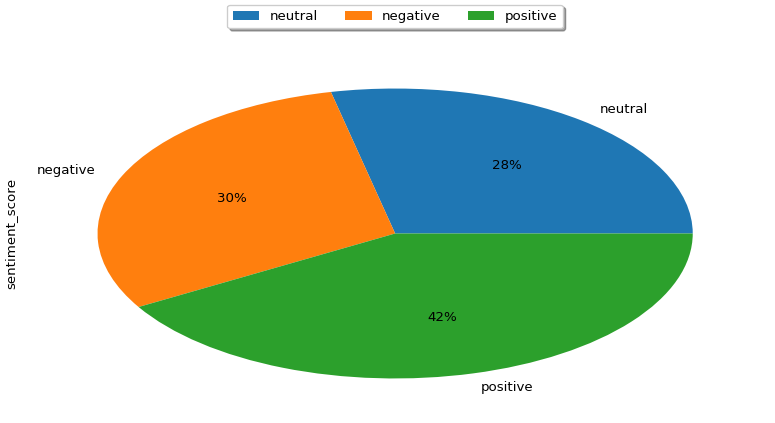

In [17]:
# Call Pixiedust to visualize sentiment data
display(callcenterlogs_nluDF)